In [144]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Tuple
from scipy.special import logsumexp
from scipy.stats import norm

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [3]:
batch_size = 128
log_interval = 10
torch.manual_seed(50)

In [4]:
# Tranformation that adds random uniform noise [0 - 1]
# to an iamge, which is done similairly to how they do it in the paper.
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256.)

In [5]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
train_loader = DataLoader(
    datasets.MNIST(root, train=True, download=True,
                   transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(
    datasets.MNIST(root, train=False, transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)

In [22]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=device):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), F.softplus(self.enc_sigma(h2))

    def reparameterize(self, mu: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        # std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, std = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, std)
        return self.decode(z), mu, 2. * torch.log(std)

In [7]:
# loss function for bernoulli
def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

In [8]:
# function to compute the log norm constant
def sumlogC(x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

# loss function for continuous bernoulli
def loss_cb(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = sumlogC(recon_x)
    return BCE + KLD + LOGC, BCE, KLD # = -ELBO

In [9]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, loss: callable, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        x = x.view(-1, 784)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [10]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader, loss: callable) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            x = x.view(-1, 784)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [11]:
EPOCHS = 100
model = VAE(hidden_dims=[500, 500, 20, 500, 500]) # NOTE: 20D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader, loss=loss)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader, loss=loss)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

C:\Users\Mads\AppData\Local\Temp\ipykernel_32672\402282884.py:7: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Train epoch=1 [0/60000]	 loss=546.1054077148438
BCE=69639.140625 KLD=262.35064697265625
Train epoch=1 [3200/60000]	 loss=215.36569213867188
BCE=27428.671875 KLD=138.13739013671875
Train epoch=1 [6400/60000]	 loss=204.03492736816406
BCE=25922.564453125 KLD=193.90652465820312
Train epoch=1 [9600/60000]	 loss=205.10140991210938
BCE=26028.85546875 KLD=224.1240234375
Train epoch=1 [12800/60000]	 loss=208.11526489257812
BCE=26313.76171875 KLD=324.99127197265625
Train epoch=1 [16000/60000]	 loss=192.98593139648438
BCE=24209.2890625 KLD=492.9111328125
Train epoch=1 [19200/60000]	 loss=194.6158905029297
BCE=24263.158203125 KLD=647.67578125
Train epoch=1 [22400/60000]	 loss=183.30963134765625
BCE=22711.8671875 KLD=751.7650146484375
Train epoch=1 [25600/60000]	 loss=184.76100158691406
BCE=22786.4921875 KLD=862.915771484375
Train epoch=1 [28800/60000]	 loss=180.1498565673828
BCE=22165.62890625 KLD=893.5518798828125
Train epoch=1 [32000/60000]	 loss=174.21102905273438
BCE=21115.966796875 KLD=1183.0

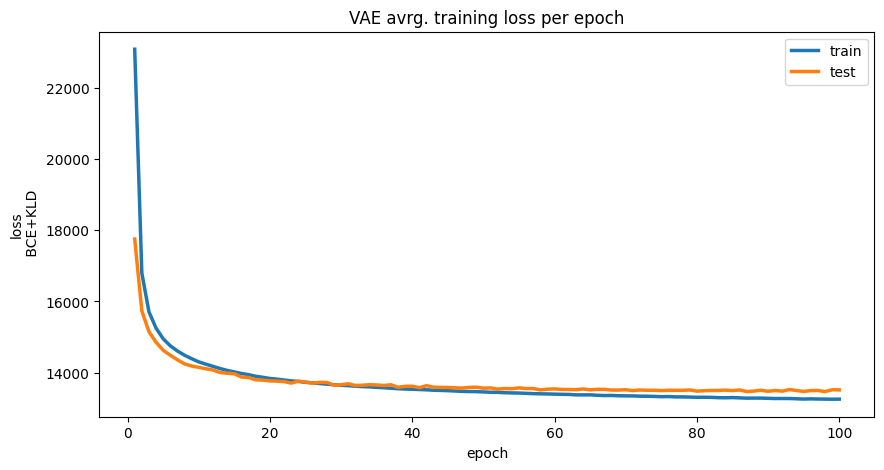

In [19]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [20]:
model.eval()
with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        #imshow(torchvision.utils.make_grid(sample[:16], 16 ))
        save_image(sample.view(64, 1, 28, 28),
                   'sample_' + str(2) + '.png')

In [12]:
EPOCHS = 100
model_cb = VAE(hidden_dims=[500, 500, 20, 500, 500]) # NOTE: 20D latent space
optimizer = optim.Adam(model_cb.parameters(), lr=1e-3)

In [22]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model_cb, epoch=e, train_loader=train_loader, loss=loss_cb)
    test_loss_vals = test(model_cb, epoch=e, test_loader=test_loader, loss=loss_cb)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=1089.656005859375
BCE=69599.171875 KLD=275.2318115234375
Train epoch=1 [3200/60000]	 loss=926.8817138671875
BCE=39725.1875 KLD=213.64602661132812
Train epoch=1 [6400/60000]	 loss=925.28466796875
BCE=38971.6484375 KLD=56.26333999633789
Train epoch=1 [9600/60000]	 loss=923.7235107421875
BCE=38725.45703125 KLD=54.01485824584961
Train epoch=1 [12800/60000]	 loss=921.4869384765625
BCE=38294.40625 KLD=59.808876037597656
Train epoch=1 [16000/60000]	 loss=921.3904418945312
BCE=38508.078125 KLD=164.17233276367188
Train epoch=1 [19200/60000]	 loss=919.8079833984375
BCE=37723.41796875 KLD=195.39254760742188
Train epoch=1 [22400/60000]	 loss=916.219482421875
BCE=36861.9453125 KLD=322.67694091796875
Train epoch=1 [25600/60000]	 loss=917.7406616210938
BCE=37149.203125 KLD=417.521728515625
Train epoch=1 [28800/60000]	 loss=914.634765625
BCE=36365.7734375 KLD=429.2216491699219
Train epoch=1 [32000/60000]	 loss=913.8604736328125
BCE=36448.69140625 KLD=538.5387573242188
Tra

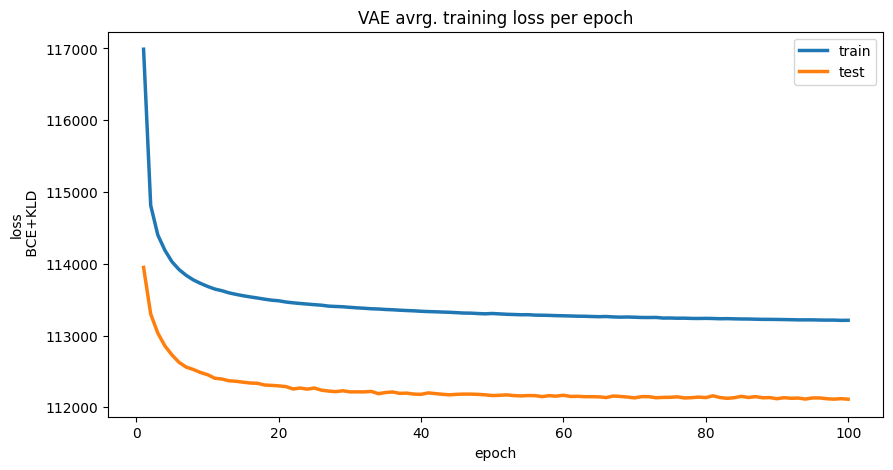

In [23]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [13]:
# save the model
save_model = False

if save_model:
    model_path = './trained_models/Bernoulli_VAE'
    torch.save(model.state_dict(), model_path)

    model_path = './trained_models/Continuous_Bernoulli_VAE'
    torch.save(model_cb.state_dict(), model_path)

In [20]:
model.load_state_dict(torch.load('./trained_models/Bernoulli_VAE', map_location=device))
model_cb.load_state_dict(torch.load('./trained_models/Continuous_Bernoulli_VAE', map_location=device))

<All keys matched successfully>

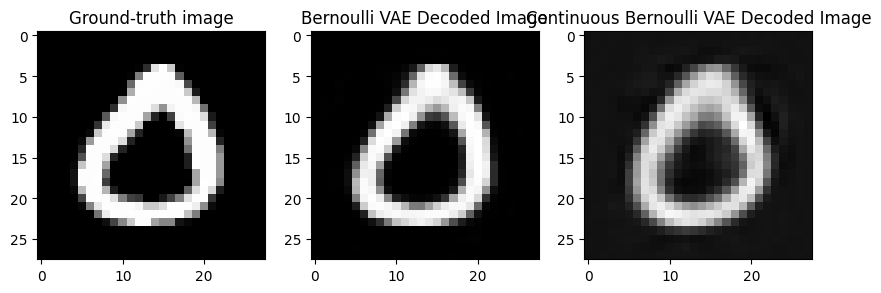

In [191]:
lst = []
for batch_idx, (x, _) in enumerate(train_loader):
    lst.append(x)
    break

idx = 5
img = lst[0][idx].view(28, 28)

model_img, _, _ = model.forward(lst[0][idx].to(device))
model_cb_img, _, _ = model_cb.forward(lst[0][idx].to(device))


f, axarr = plt.subplots(1,3)
axarr[0].imshow(img.detach().cpu().numpy(), cmap='gray')
axarr[0].set_title('Ground-truth image')
axarr[1].imshow(model_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[1].set_title('Bernoulli VAE Decoded Image')
axarr[2].imshow(model_cb_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[2].set_title('Continuous Bernoulli VAE Decoded Image')

plt.show()

In [59]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(torchvision.utils.make_grid(x.unsqueeze(1).detach().cpu(), padding=2, normalize=True).permute(1, 2, 0))

## Comparison between models

In [114]:
num_samples = 64

samples = torch.randn(size=(num_samples, 20))

In [115]:
model_samples = model.decode(samples).view(-1, 28, 28)
model_cb_samples = model_cb.decode(samples).view(-1, 28, 28)

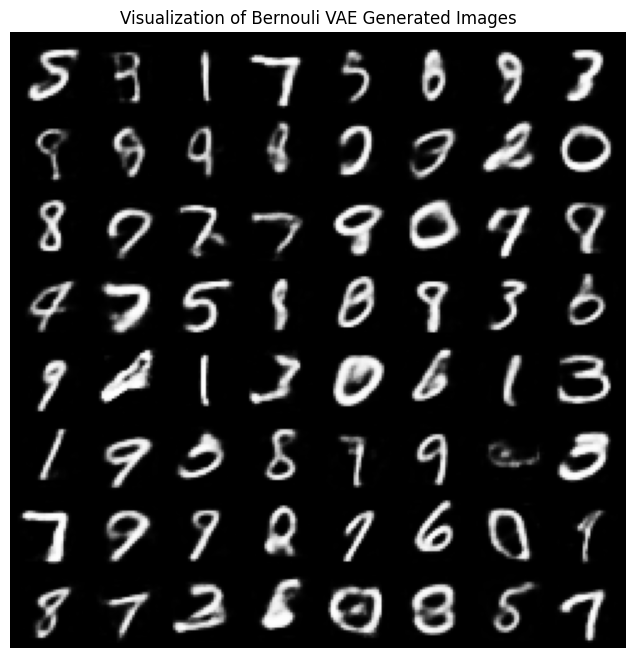

In [116]:
draw_sample_image(model_samples, "Bernouli VAE Generated Images")

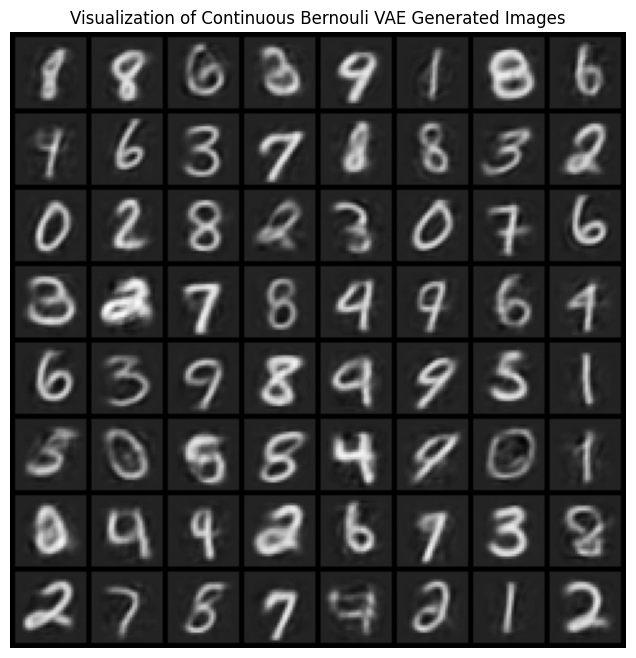

In [117]:
draw_sample_image(model_cb_samples, "Continuous Bernouli VAE Generated Images")

## Importance Sampling

In [142]:
train_data = train_loader.dataset.data / 255

In [202]:
def compute_samples(data, num_samples, m):
    """ Sample from importance distribution z_samples ~ q(z|X) and
        compute p(z_samples), q(z_samples) for importance sampling
    """
    z_mean, z_log_sigma = m.encode(data)
    z_mean = z_mean.detach().cpu().numpy()
    z_log_sigma = z_log_sigma.detach().cpu().numpy()
    z_samples = []
    qz = []
    
    for m, s in zip(z_mean, z_log_sigma):
        z_vals = [np.random.normal(m[i], np.exp(s[i]), num_samples)
                  for i in range(len(m))]
    
        qz_vals = [norm.pdf(z_vals[i], loc=m[i], scale=np.exp(s[i]))
                  for i in range(len(m))]
        z_samples.append(z_vals)
        qz.append(qz_vals)
    
    z_samples = np.array(z_samples)
    pz = norm.pdf(z_samples)
    qz = np.array(qz)
    
    z_samples = np.swapaxes(z_samples, 1, 2)
    pz = np.swapaxes(pz, 1, 2)
    qz = np.swapaxes(qz, 1, 2)
    
    return torch.from_numpy(z_samples).float(), pz, qz

In [203]:
def estimate_logpx_batch(data, num_samples, m):
    z_samples, pz, qz = compute_samples(data.view(-1, 784), num_samples, model)
    assert len(z_samples) == len(data)
    assert len(z_samples) == len(pz)
    assert len(z_samples) == len(qz)
    
    # Calculate importance sample
    # \log p(x) = E_p[p(x|z)]
    # = \log(\int p(x|z) p(z) dz)
    # = \log(\int p(x|z) p(z) / q(z|x) q(z|x) dz)
    # = E_q[p(x|z) p(z) / q(z|x)]
    # ~= \log(1/n * \sum_i p(x|z_i) p(z_i)/q(z_i))
    # = \log p(x) = \log(1/n * \sum_i e^{\log p(x|z_i) + \log p(z_i) - \log q(z_i)})
    # = \log p(x) = -\logn + \logsumexp_i(\log p(x|z_i) + \log p(z_i) - \log q(z_i))
    # See: scipy.special.logsumexp
    result = []
    for i in range(len(data)):
        datum = data[i].detach().cpu().numpy().reshape(784)
        x_predict = m.decode(z_samples[i]).detach().cpu().numpy().reshape(-1, 784)
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        # \log p(x|z) = Binary cross entropy
        logp_xz = np.sum(datum * np.log(x_predict + 1e-10) + (1. - datum) * np.log(1.0 - x_predict + 1e-10), axis=-1)
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
            
    return np.array(result)


def estimate_logpx_batch_cb(data, num_samples, m):
    z_samples, pz, qz = compute_samples(data.view(-1, 784), num_samples, model)
    assert len(z_samples) == len(data)
    assert len(z_samples) == len(pz)
    assert len(z_samples) == len(qz)
    
    # Calculate importance sample
    # \log p(x) = E_p[p(x|z)]
    # = \log(\int p(x|z) p(z) dz)
    # = \log(\int p(x|z) p(z) / q(z|x) q(z|x) dz)
    # = E_q[p(x|z) p(z) / q(z|x)]
    # ~= \log(1/n * \sum_i p(x|z_i) p(z_i)/q(z_i))
    # = \log p(x) = \log(1/n * \sum_i e^{\log p(x|z_i) + \log p(z_i) - \log q(z_i)})
    # = \log p(x) = -\logn + \logsumexp_i(\log p(x|z_i) + \log p(z_i) - \log q(z_i))
    # See: scipy.special.logsumexp
    result = []
    for i in range(len(data)):
        datum = data[i].detach().cpu().numpy().reshape(784)
        x_predict = m.decode(z_samples[i]).detach().cpu().numpy().reshape(-1, 784)
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        # \log p(x|z) = Binary cross entropy + log_constant
        logp_xz = np.sum(datum * np.log(x_predict + 1e-10) + (1. - datum) * np.log(1.0 - x_predict + 1e-10), axis=-1) + sumlogC(torch.from_numpy(x_predict)).detach().cpu().numpy()
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
            
    return np.array(result)

In [204]:
def estimate_logpx(data, num_samples, m, verbosity=0, cb=False):
    batches = []
    iterations = int(np.ceil(1. * len(data) / batch_size))
    for b in range(iterations):
        batch_data = data[b * batch_size:(b+1) * batch_size]
        if cb:
            batches.append(estimate_logpx_batch_cb(batch_data, num_samples, m))
        else:
            batches.append(estimate_logpx_batch(batch_data, num_samples, m))
        if verbosity and b % max(11 - verbosity, 1) == 0:
            print("Batch %d [%d, %d]: %.2f" % (b, b*batch_size, (b+1) * batch_size, 
                                               np.mean(np.concatenate(batches))))
            np.mean(np.concatenate(batches))        
    return np.mean(np.concatenate(batches))

num_samples = 128

logpx = estimate_logpx(train_data, num_samples, model_cb, verbosity=1, cb=True)
print("log p(x) = %.2f" % logpx)

Batch 0 [0, 128]: 84815.62
Batch 10 [1280, 1408]: 84832.78
Batch 20 [2560, 2688]: 84831.08
Batch 30 [3840, 3968]: 84818.71


KeyboardInterrupt: 

In [355]:
def constant(lambda_, eps=1e-5):
    c = 2. * torch.arctanh(1. - 2. * lambda_) / (1. - 2. * lambda_)

    return c

def logConstant(x):
    if abs(x - 0.5) < 1e-3:
        val = torch.log(torch.tensor(2))
        v = 1. - 2. * x
        v_squared = v ** 2
        taylor = 1
        e = 1
        for i in range(1, 10):
            e *= v_squared
            taylor += e / (2. * i + 1)
        return val + torch.log(taylor)
    return torch.log(constant(x))

In [251]:
l = torch.tensor(0.499)
print(torch.log(constant(l)))
print(logConstant(l))

l = torch.tensor(0.5-1e-17)
print(torch.log(constant(l)))
print(logConstant(l))

tensor(0.6931)
tensor(0.6931)
tensor(nan)
tensor(0.6931)
